# OpenNILM - Model Evaluation (PyTorch)

This notebook covers:
1. **Model Loading**: Load trained model from checkpoint
2. **Inference**: Generate predictions on test data
3. **Metrics Calculation**: MAE, F1, Precision, Recall, Accuracy
4. **Visualization**: Prediction plots and confusion analysis
5. **Error Analysis**: Detailed error distribution analysis

---

## Google Colab Setup

**Before running this notebook on Colab:**
1. Upload your OpenNILM folder to Google Drive
2. Make sure training is complete and checkpoint exists
3. Run the setup cells below

---

## 0. Google Colab Setup (Run these cells first!)

In [1]:
# ============================================================================
# COLAB DETECTION AND SETUP
# ============================================================================
import sys

# Detect if running on Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Google Colab")
    print("  -> Please run the following cells to set up your environment")
else:
    print("Running locally")
    print("  -> You can skip the Colab setup cells below")

Running locally
  -> You can skip the Colab setup cells below


In [2]:
# ============================================================================
# MOUNT GOOGLE DRIVE (Colab only)
# ============================================================================
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted at /content/drive")

In [3]:
# ============================================================================
# INSTALL DEPENDENCIES (Colab only)
# ============================================================================
if IN_COLAB:
    !pip install -q hydra-core omegaconf
    print("Dependencies installed")

In [4]:
# ============================================================================
# SET PROJECT PATH
# ============================================================================
import os
from pathlib import Path

if IN_COLAB:
    # =========================================================================
    # CONFIGURE YOUR GOOGLE DRIVE PATH HERE
    # =========================================================================
    # Change this to match where you uploaded the OpenNILM folder in Google Drive
    
    DRIVE_PROJECT_PATH = '/content/drive/MyDrive/OpenNILM'  # <-- EDIT THIS PATH
    
    # =========================================================================
    
    project_root = Path(DRIVE_PROJECT_PATH)
    
    if not project_root.exists():
        print(f"ERROR: Project folder not found at: {project_root}")
        print(f"\nPlease either:")
        print(f"  1. Upload your OpenNILM folder to Google Drive")
        print(f"  2. OR edit DRIVE_PROJECT_PATH above to match your folder location")
    else:
        print(f"Project folder found at: {project_root}")
        os.chdir(project_root)
        print(f"Changed working directory to: {os.getcwd()}")
else:
    # Local setup
    project_root = Path(os.getcwd()).parent
    print(f"Project root: {project_root}")

# Add src_pytorch to Python path
sys.path.insert(0, str(project_root))

Project root: c:\Users\s.athanasoulias\OneDrive - Accenture\Desktop\ENERGIZE


## 1. Setup and Imports

In [5]:
# ============================================================================
# IMPORTS
# ============================================================================
# Note: os, sys, Path, and project_root are already set up in the Colab setup cells above

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import (
    mean_absolute_error, 
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)
from tqdm import tqdm

# PyTorch NILM modules
from src_pytorch import (
    CNN_NILM, GRU_NILM, TCN_NILM, get_model,
    SimpleNILMDataLoader,
    SimpleTester,
    set_seeds, get_device, count_parameters
)

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0+cpu
CUDA available: False


In [6]:
# Set seeds and get device
set_seeds(42)
device = get_device()

Seeds set to 42
CUDA not available, using CPU


## 2. Configuration

**Important**: Make sure these match the settings used during training!

In [10]:
# ============================================
# CONFIGURATION - Must match training settings
# ============================================

# Dataset configuration
DATASET_NAME = 'plegma'          # 'refit' or 'plegma'
APPLIANCE_NAME = 'boiler'        # Must match training

# Model configuration
MODEL_NAME = 'tcn'               # 'cnn', 'gru', or 'tcn'

# Model-specific parameters
MODEL_CONFIGS = {
    'cnn': {
        'input_window_length': 299,
        'batch_size': 1024
    },
    'gru': {
        'input_window_length': 199,
        'batch_size': 1200
    },
    'tcn': {
        'input_window_length': 600,
        'batch_size': 50,
        'depth': 9,
        'nb_filters': [512, 256, 256, 128, 128, 256, 256, 256, 512],
        'dropout': 0.2,
        'stacks': 1
    }
}

# REFIT appliance parameters
REFIT_PARAMS = {
    'dishwasher': {'threshold': 10, 'cutoff': 2500, 'mean': 602.55, 'std': 828.11},
    'washing_machine': {'threshold': 20, 'cutoff': 2500, 'mean': 512.30, 'std': 816.25},
    'kettle': {'threshold': 2000, 'cutoff': 3000, 'mean': 500.10, 'std': 749.24},
    'microwave': {'threshold': 200, 'cutoff': 1300, 'mean': 489.55, 'std': 696.09},
    'refrigerator': {'threshold': 5, 'cutoff': 1700, 'mean': 600.18, 'std': 944.55}
}

# PLEGMA appliance parameters
PLEGMA_PARAMS = {
    'ac_1': {'threshold': 50, 'cutoff': 2300, 'mean': 345.71, 'std': 723.03},
    'boiler': {'threshold': 50, 'cutoff': 5000, 'mean': 347.59, 'std': 745.19},
    'washing_machine': {'threshold': 50, 'cutoff': 2600, 'mean': 344.49, 'std': 731.61},
    'fridge': {'threshold': 50, 'cutoff': 400, 'mean': 328.16, 'std': 710.16}
}

# Select appropriate parameters based on dataset
APPLIANCE_PARAMS = REFIT_PARAMS if DATASET_NAME == 'refit' else PLEGMA_PARAMS

# Get appliance parameters
THRESHOLD = APPLIANCE_PARAMS[APPLIANCE_NAME]['threshold']
CUTOFF = APPLIANCE_PARAMS[APPLIANCE_NAME]['cutoff']

# Paths
DATA_DIR = project_root / 'data' / 'processed' / DATASET_NAME / APPLIANCE_NAME
OUTPUT_DIR = project_root / 'outputs' / f'{MODEL_NAME}_{APPLIANCE_NAME}'
CHECKPOINT_PATH = OUTPUT_DIR / 'checkpoint' / 'model.pt'

# Get model-specific config
model_config = MODEL_CONFIGS[MODEL_NAME]
INPUT_WINDOW_LENGTH = model_config['input_window_length']
BATCH_SIZE = model_config['batch_size']

print(f"Dataset: {DATASET_NAME}")
print(f"Appliance: {APPLIANCE_NAME}")
print(f"Model: {MODEL_NAME}")
print(f"Input window length: {INPUT_WINDOW_LENGTH}")
print(f"Threshold: {THRESHOLD} W")
print(f"Cutoff: {CUTOFF} W")
print(f"Checkpoint path: {CHECKPOINT_PATH}")

Dataset: plegma
Appliance: boiler
Model: tcn
Input window length: 600
Threshold: 50 W
Cutoff: 5000 W
Checkpoint path: c:\Users\s.athanasoulias\OneDrive - Accenture\Desktop\ENERGIZE\outputs\tcn_boiler\checkpoint\model.pt


## 3. Load Model and Data

In [11]:
# Create the model
if MODEL_NAME == 'cnn':
    model = CNN_NILM(input_window_length=INPUT_WINDOW_LENGTH)
elif MODEL_NAME == 'gru':
    model = GRU_NILM(input_window_length=INPUT_WINDOW_LENGTH)
elif MODEL_NAME == 'tcn':
    model = TCN_NILM(
        input_window_length=INPUT_WINDOW_LENGTH,
        depth=model_config.get('depth', 9),
        nb_filters=model_config.get('nb_filters'),
        dropout=model_config.get('dropout', 0.1),
        stacks=model_config.get('stacks', 1)
    )

# Load weights
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
model = model.to(device)
model.eval()

print(f"Model loaded from: {CHECKPOINT_PATH}")
print(f"Total parameters: {count_parameters(model):,}")

Model loaded from: c:\Users\s.athanasoulias\OneDrive - Accenture\Desktop\ENERGIZE\outputs\tcn_boiler\checkpoint\model.pt
Total parameters: 3,220,481


In [12]:
# Load data
data_loader = SimpleNILMDataLoader(
    data_dir=str(DATA_DIR),
    model_name=MODEL_NAME,
    batch_size=BATCH_SIZE,
    input_window_length=INPUT_WINDOW_LENGTH,
    train=True,
    num_workers=0
)

test_loader = data_loader.test

print(f"Test batches: {len(test_loader)}")
print(f"Test data shape: {data_loader.test_data.shape}")
print(f"Test labels shape: {data_loader.test_labels.shape}")

Test batches: 55
Test data shape: (1627136,)
Test labels shape: (1627136,)


## 4. Generate Predictions

In [13]:
@torch.no_grad()
def predict(model, data_loader, device):
    """Generate predictions for all data in the loader."""
    model.eval()
    predictions = []
    
    for batch_x, _ in tqdm(data_loader, desc="Generating predictions"):
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        predictions.append(outputs.cpu().numpy())
    
    return np.concatenate(predictions).flatten()

# Generate predictions
predictions_normalized = predict(model, test_loader, device)
print(f"Predictions shape: {predictions_normalized.shape}")

Generating predictions: 100%|██████████| 55/55 [00:29<00:00,  1.85it/s]

Predictions shape: (1626600,)


In [14]:
# Align ground truth with predictions based on model type
ground_truth_normalized = data_loader.test_labels.copy()

if MODEL_NAME == 'cnn':
    offset = int(INPUT_WINDOW_LENGTH / 2) - 1
    ground_truth_normalized = ground_truth_normalized[offset:]
    ground_truth_normalized = ground_truth_normalized[:len(predictions_normalized)]
elif MODEL_NAME == 'gru':
    offset = INPUT_WINDOW_LENGTH - 1
    ground_truth_normalized = ground_truth_normalized[offset:]
    ground_truth_normalized = ground_truth_normalized[:len(predictions_normalized)]
elif MODEL_NAME == 'tcn':
    ground_truth_normalized = ground_truth_normalized[:len(predictions_normalized)]

print(f"Aligned ground truth shape: {ground_truth_normalized.shape}")
print(f"Predictions shape: {predictions_normalized.shape}")

Aligned ground truth shape: (1626600,)
Predictions shape: (1626600,)


In [15]:
# Denormalize to actual power values
ground_truth = ground_truth_normalized * CUTOFF
predictions = predictions_normalized * CUTOFF

# Apply threshold and clipping
predictions_clipped = predictions.copy()
predictions_clipped[predictions_clipped < THRESHOLD] = 0
predictions_clipped[predictions_clipped > CUTOFF] = CUTOFF

print(f"Ground truth range: [{ground_truth.min():.2f}, {ground_truth.max():.2f}] W")
print(f"Predictions range: [{predictions_clipped.min():.2f}, {predictions_clipped.max():.2f}] W")

Ground truth range: [0.00, 3822.50] W
Predictions range: [0.00, 5000.00] W


## 5. Calculate Metrics

In [16]:
def compute_metrics(ground_truth, predictions, threshold):
    """Compute all NILM evaluation metrics."""
    # MAE
    mae = mean_absolute_error(ground_truth, predictions)
    
    # Binary classification (ON/OFF)
    gt_binary = (ground_truth >= threshold).astype(int)
    pred_binary = (predictions >= threshold).astype(int)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(gt_binary, pred_binary, labels=[0, 1]).ravel()
    
    # Metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / max(tp + fp, 1e-9)
    recall = tp / max(tp + fn, 1e-9)
    f1 = 2 * precision * recall / max(precision + recall, 1e-9)
    
    # Energy metrics
    total_gt_energy = np.sum(ground_truth) / 3600  # Wh (assuming 1s sampling)
    total_pred_energy = np.sum(predictions) / 3600  # Wh
    energy_error = abs(total_gt_energy - total_pred_energy) / max(total_gt_energy, 1e-9) * 100
    
    return {
        'mae': mae,
        'f1': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'total_gt_energy_wh': total_gt_energy,
        'total_pred_energy_wh': total_pred_energy,
        'energy_error_percent': energy_error
    }

metrics = compute_metrics(ground_truth, predictions_clipped, THRESHOLD)

print("=" * 60)
print("EVALUATION METRICS")
print("=" * 60)
print(f"Mean Absolute Error (MAE): {metrics['mae']:.4f} W")
print(f"\nClassification Metrics (ON/OFF detection):")
print(f"  Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"  Precision: {metrics['precision']:.4f}")
print(f"  Recall:    {metrics['recall']:.4f}")
print(f"  F1 Score:  {metrics['f1']:.4f}")
print(f"\nConfusion Matrix:")
print(f"  True Positives:  {metrics['tp']:,}")
print(f"  True Negatives:  {metrics['tn']:,}")
print(f"  False Positives: {metrics['fp']:,}")
print(f"  False Negatives: {metrics['fn']:,}")
print(f"\nEnergy Metrics:")
print(f"  Ground Truth Total Energy: {metrics['total_gt_energy_wh']:.2f} Wh")
print(f"  Predicted Total Energy:    {metrics['total_pred_energy_wh']:.2f} Wh")
print(f"  Energy Error:              {metrics['energy_error_percent']:.2f}%")
print("=" * 60)

EVALUATION METRICS
Mean Absolute Error (MAE): 22.5772 W

Classification Metrics (ON/OFF detection):
  Accuracy:  0.9931 (99.31%)
  Precision: 0.7164
  Recall:    0.9911
  F1 Score:  0.8317

Confusion Matrix:
  True Positives:  27,722
  True Negatives:  1,587,656
  False Positives: 10,973
  False Negatives: 249

Energy Metrics:
  Ground Truth Total Energy: 27678.10 Wh
  Predicted Total Energy:    32383.94 Wh
  Energy Error:              17.00%


## 6. Visualizations

### 6.1 Time Series Comparison

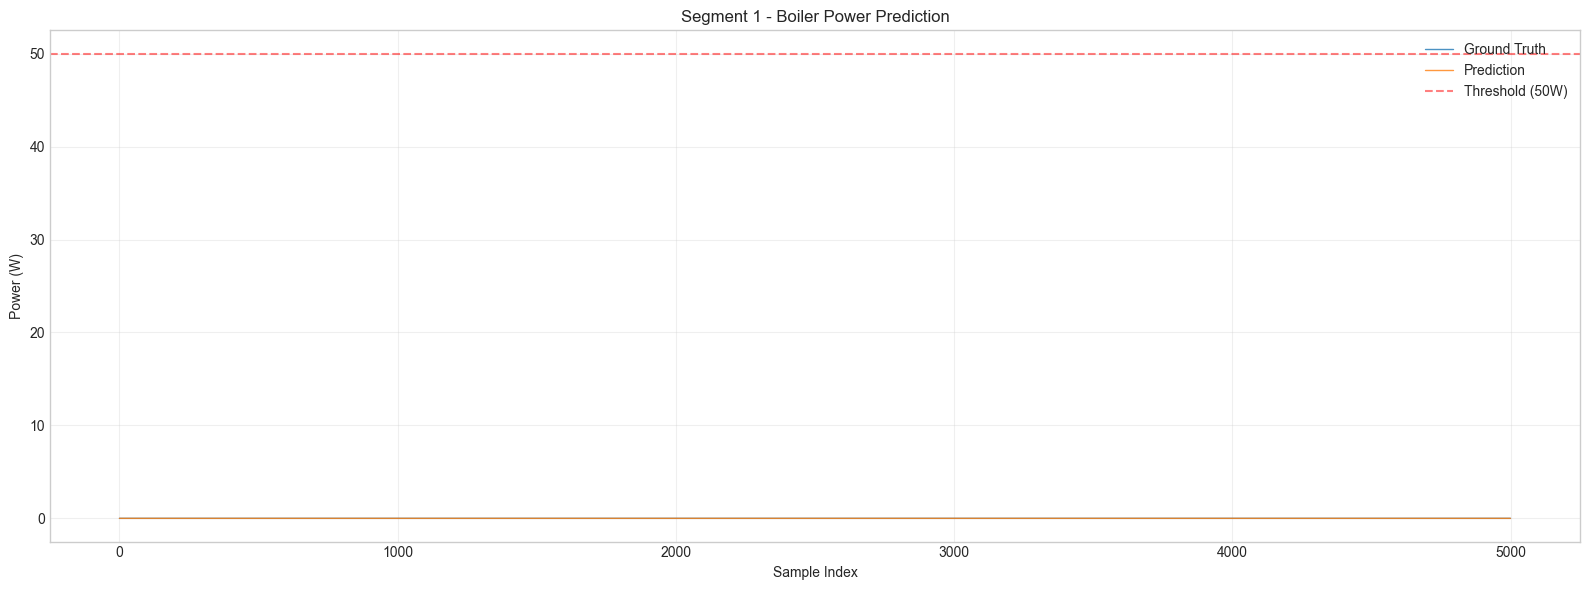

In [17]:
# Plot a segment of predictions vs ground truth
def plot_predictions(ground_truth, predictions, start_idx=0, length=5000, title=""):
    """Plot ground truth vs predictions for a segment."""
    end_idx = min(start_idx + length, len(ground_truth))
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    x = np.arange(start_idx, end_idx)
    ax.plot(x, ground_truth[start_idx:end_idx], label='Ground Truth', alpha=0.8, linewidth=1)
    ax.plot(x, predictions[start_idx:end_idx], label='Prediction', alpha=0.8, linewidth=1)
    ax.fill_between(x, 0, ground_truth[start_idx:end_idx], alpha=0.3)
    ax.fill_between(x, 0, predictions[start_idx:end_idx], alpha=0.3)
    
    ax.axhline(y=THRESHOLD, color='r', linestyle='--', label=f'Threshold ({THRESHOLD}W)', alpha=0.5)
    
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Power (W)')
    ax.set_title(f'{title} - {APPLIANCE_NAME.capitalize()} Power Prediction')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot several segments
fig = plot_predictions(ground_truth, predictions_clipped, start_idx=0, length=5000, title="Segment 1")
plt.savefig(OUTPUT_DIR / 'figures' / 'prediction_segment1.png', dpi=150)
plt.show()

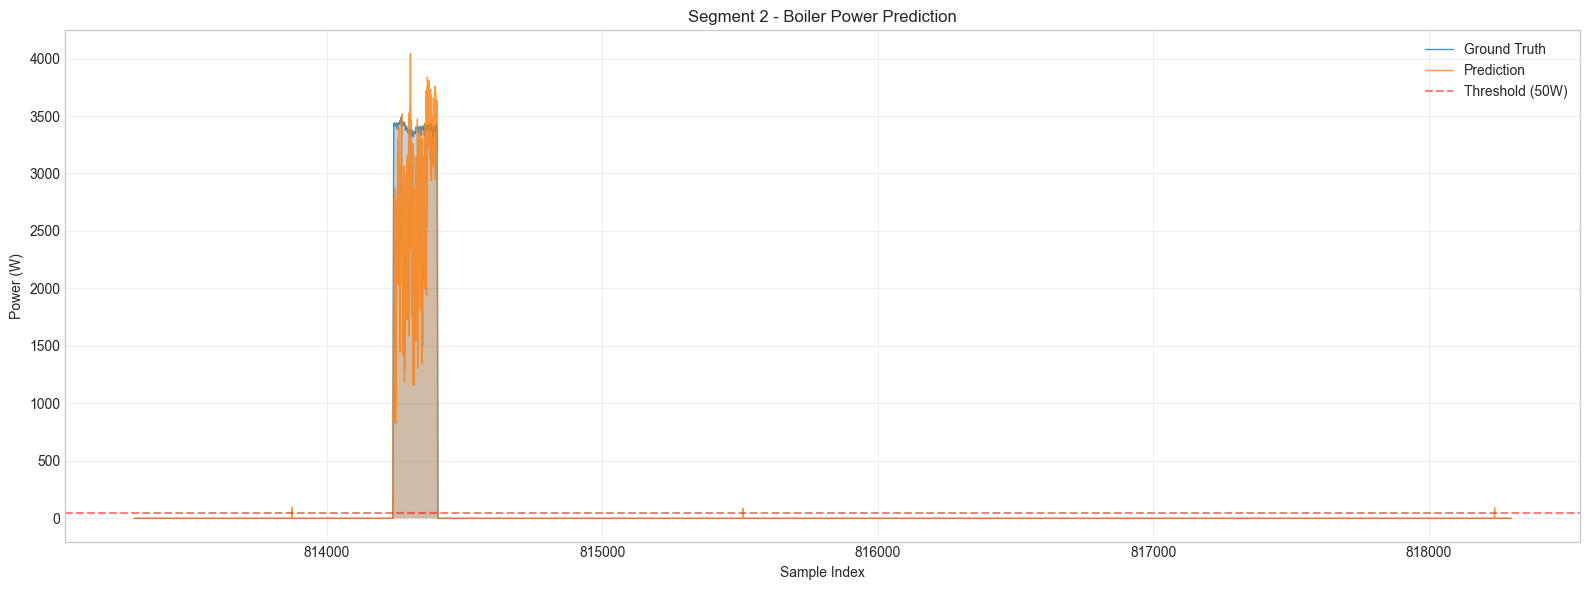

In [18]:
# Plot middle segment
mid_point = len(ground_truth) // 2
fig = plot_predictions(ground_truth, predictions_clipped, start_idx=mid_point, length=5000, title="Segment 2")
plt.savefig(OUTPUT_DIR / 'figures' / 'prediction_segment2.png', dpi=150)
plt.show()

### 6.2 Confusion Matrix

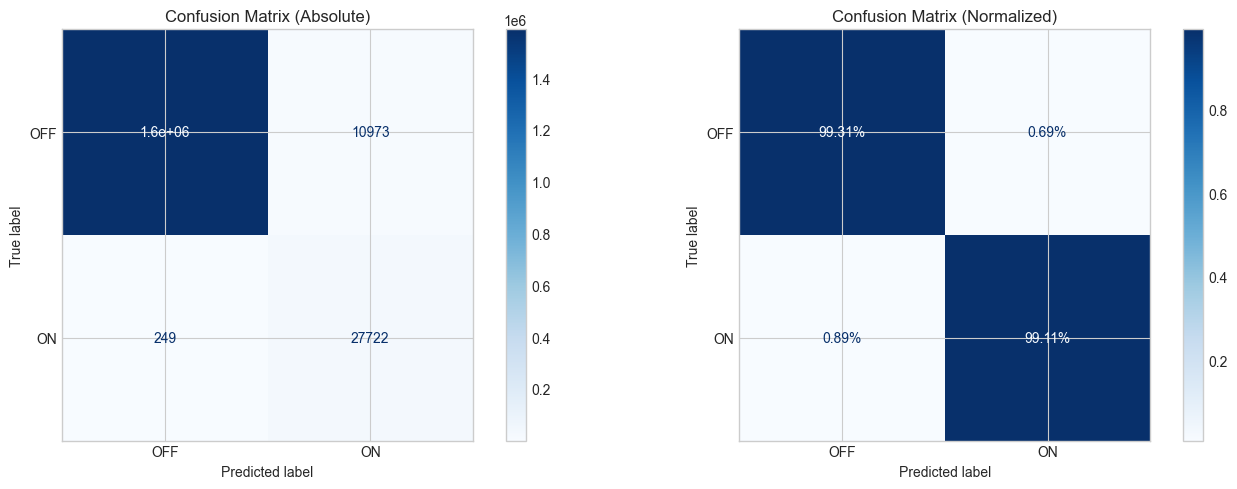


Classification Report:
              precision    recall  f1-score   support

         OFF       1.00      0.99      1.00   1598629
          ON       0.72      0.99      0.83     27971

    accuracy                           0.99   1626600
   macro avg       0.86      0.99      0.91   1626600
weighted avg       0.99      0.99      0.99   1626600



In [19]:
# Binary classification
gt_binary = (ground_truth >= THRESHOLD).astype(int)
pred_binary = (predictions_clipped >= THRESHOLD).astype(int)

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute values
cm = confusion_matrix(gt_binary, pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OFF', 'ON'])
disp.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix (Absolute)')

# Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['OFF', 'ON'])
disp_norm.plot(ax=axes[1], cmap='Blues', values_format='.2%')
axes[1].set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'confusion_matrix.png', dpi=150)
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(gt_binary, pred_binary, target_names=['OFF', 'ON']))

### 6.3 Error Distribution

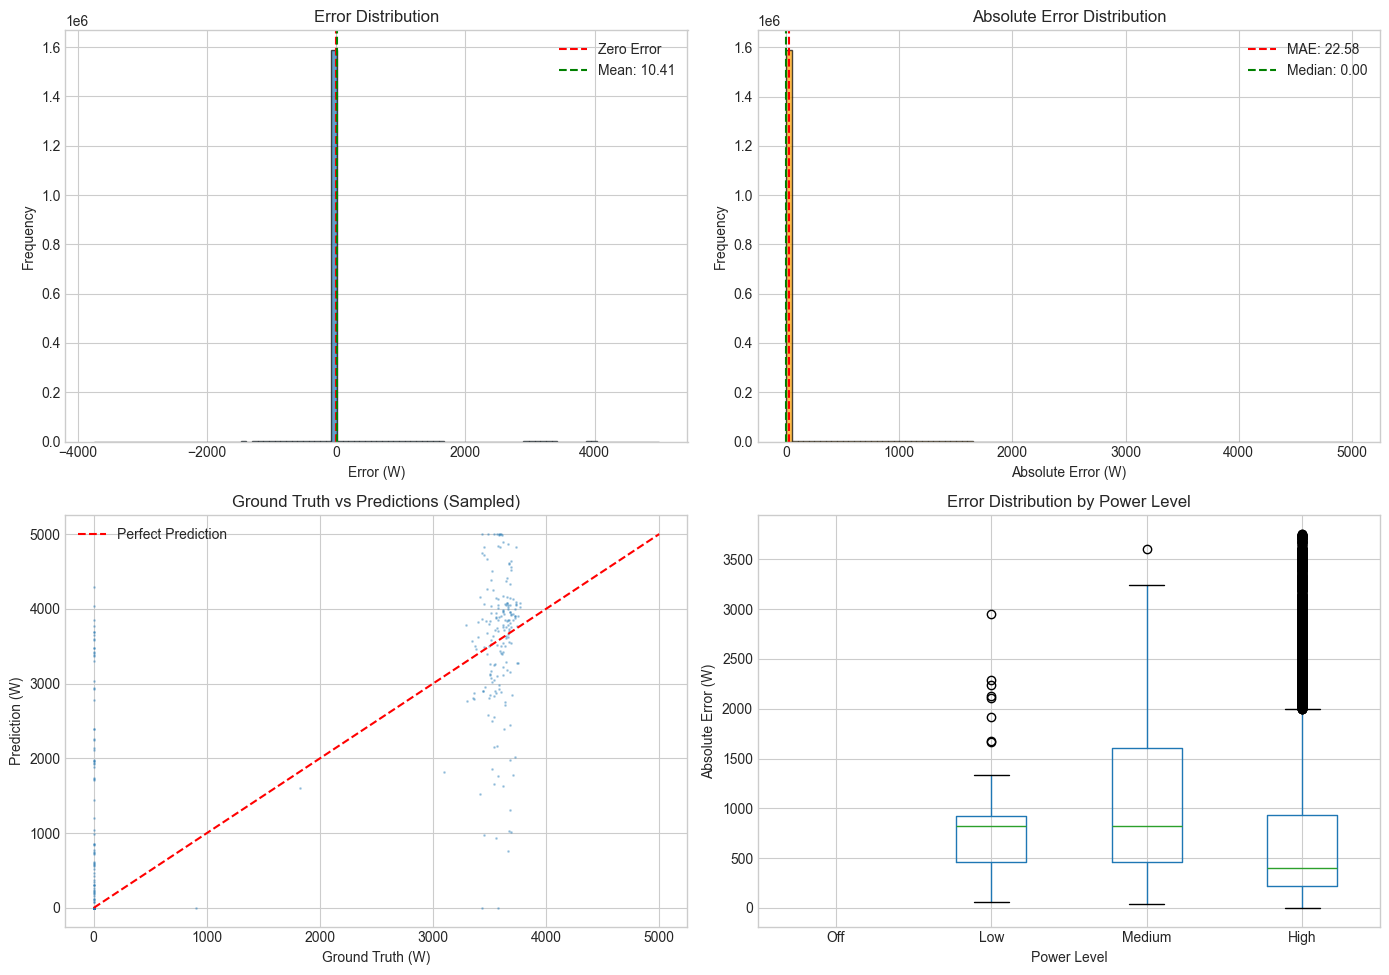


Error Statistics:
  Mean Error: 10.4150 W
  Std Error: 218.3820 W
  MAE: 22.5772 W
  Median Absolute Error: 0.0000 W
  Max Absolute Error: 5000.0000 W
  90th Percentile Error: 0.0000 W
  95th Percentile Error: 0.0000 W


In [20]:
# Calculate errors
errors = predictions_clipped - ground_truth
abs_errors = np.abs(errors)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Error histogram
axes[0, 0].hist(errors, bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0, color='r', linestyle='--', label='Zero Error')
axes[0, 0].axvline(x=np.mean(errors), color='g', linestyle='--', label=f'Mean: {np.mean(errors):.2f}')
axes[0, 0].set_xlabel('Error (W)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Error Distribution')
axes[0, 0].legend()

# Absolute error histogram
axes[0, 1].hist(abs_errors, bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].axvline(x=np.mean(abs_errors), color='r', linestyle='--', label=f'MAE: {np.mean(abs_errors):.2f}')
axes[0, 1].axvline(x=np.median(abs_errors), color='g', linestyle='--', label=f'Median: {np.median(abs_errors):.2f}')
axes[0, 1].set_xlabel('Absolute Error (W)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Absolute Error Distribution')
axes[0, 1].legend()

# Scatter plot: Ground Truth vs Predictions
sample_indices = np.random.choice(len(ground_truth), min(10000, len(ground_truth)), replace=False)
axes[1, 0].scatter(ground_truth[sample_indices], predictions_clipped[sample_indices], alpha=0.3, s=1)
axes[1, 0].plot([0, CUTOFF], [0, CUTOFF], 'r--', label='Perfect Prediction')
axes[1, 0].set_xlabel('Ground Truth (W)')
axes[1, 0].set_ylabel('Prediction (W)')
axes[1, 0].set_title('Ground Truth vs Predictions (Sampled)')
axes[1, 0].legend()

# Box plot of errors by power level
power_bins = pd.cut(ground_truth, bins=[0, THRESHOLD, CUTOFF/4, CUTOFF/2, CUTOFF], 
                    labels=['Off', 'Low', 'Medium', 'High'])
error_df = pd.DataFrame({'Power Level': power_bins, 'Error': abs_errors})
error_df.boxplot(column='Error', by='Power Level', ax=axes[1, 1])
axes[1, 1].set_xlabel('Power Level')
axes[1, 1].set_ylabel('Absolute Error (W)')
axes[1, 1].set_title('Error Distribution by Power Level')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'error_analysis.png', dpi=150)
plt.show()

# Print error statistics
print("\nError Statistics:")
print(f"  Mean Error: {np.mean(errors):.4f} W")
print(f"  Std Error: {np.std(errors):.4f} W")
print(f"  MAE: {np.mean(abs_errors):.4f} W")
print(f"  Median Absolute Error: {np.median(abs_errors):.4f} W")
print(f"  Max Absolute Error: {np.max(abs_errors):.4f} W")
print(f"  90th Percentile Error: {np.percentile(abs_errors, 90):.4f} W")
print(f"  95th Percentile Error: {np.percentile(abs_errors, 95):.4f} W")

### 6.4 Error Over Time

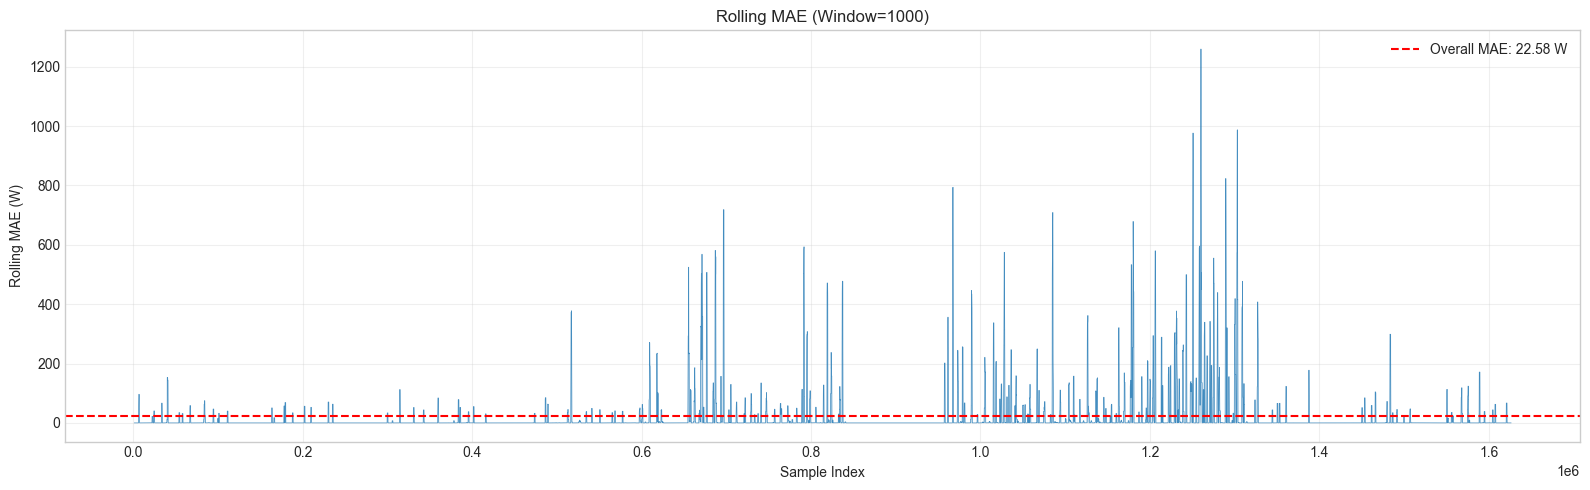

In [21]:
# Calculate rolling MAE
window_size = 1000
rolling_mae = pd.Series(abs_errors).rolling(window=window_size).mean()

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(rolling_mae, alpha=0.8, linewidth=0.5)
ax.axhline(y=np.mean(abs_errors), color='r', linestyle='--', label=f'Overall MAE: {np.mean(abs_errors):.2f} W')
ax.fill_between(range(len(rolling_mae)), 0, rolling_mae, alpha=0.3)

ax.set_xlabel('Sample Index')
ax.set_ylabel('Rolling MAE (W)')
ax.set_title(f'Rolling MAE (Window={window_size})')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'rolling_mae.png', dpi=150)
plt.show()

## 7. Save Results

In [22]:
# Create results directory
(OUTPUT_DIR / 'metrics').mkdir(exist_ok=True)

# Save metrics to CSV
metrics_df = pd.DataFrame([{
    'Model': MODEL_NAME,
    'Appliance': APPLIANCE_NAME,
    'Dataset': DATASET_NAME,
    'MAE': round(metrics['mae'], 4),
    'F1': round(metrics['f1'], 4),
    'Accuracy': round(metrics['accuracy'], 4),
    'Precision': round(metrics['precision'], 4),
    'Recall': round(metrics['recall'], 4),
    'Energy_Error_Percent': round(metrics['energy_error_percent'], 2)
}])

metrics_path = OUTPUT_DIR / 'metrics' / f'{APPLIANCE_NAME}_results.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"Metrics saved to: {metrics_path}")

# Display metrics table
metrics_df

Metrics saved to: c:\Users\s.athanasoulias\OneDrive - Accenture\Desktop\ENERGIZE\outputs\tcn_boiler\metrics\boiler_results.csv


,Model,Appliance,Dataset,MAE,F1,Accuracy,Precision,Recall,Energy_Error_Percent
0,tcn,boiler,plegma,22.5772,0.8317,0.9931,0.7164,0.9911,17.0


In [23]:
# Save predictions for further analysis
predictions_df = pd.DataFrame({
    'ground_truth': ground_truth,
    'prediction': predictions_clipped,
    'error': errors,
    'abs_error': abs_errors
})

predictions_path = OUTPUT_DIR / 'metrics' / f'{APPLIANCE_NAME}_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f"Predictions saved to: {predictions_path}")

Predictions saved to: c:\Users\s.athanasoulias\OneDrive - Accenture\Desktop\ENERGIZE\outputs\tcn_boiler\metrics\boiler_predictions.csv


## 8. Summary

In [24]:
print("=" * 70)
print("EVALUATION SUMMARY")
print("=" * 70)
print(f"\nModel Configuration:")
print(f"  Model:          {MODEL_NAME.upper()}")
print(f"  Appliance:      {APPLIANCE_NAME}")
print(f"  Dataset:        {DATASET_NAME}")
print(f"  Window Length:  {INPUT_WINDOW_LENGTH}")
print(f"  Parameters:     {count_parameters(model):,}")
print(f"\nRegression Metrics:")
print(f"  MAE:            {metrics['mae']:.4f} W")
print(f"  Energy Error:   {metrics['energy_error_percent']:.2f}%")
print(f"\nClassification Metrics (Threshold: {THRESHOLD}W):")
print(f"  Accuracy:       {metrics['accuracy']*100:.2f}%")
print(f"  F1 Score:       {metrics['f1']:.4f}")
print(f"  Precision:      {metrics['precision']:.4f}")
print(f"  Recall:         {metrics['recall']:.4f}")
print(f"\nOutput Files:")
print(f"  Metrics:     {OUTPUT_DIR / 'metrics'}")
print(f"  Figures:     {OUTPUT_DIR / 'figures'}")
print("=" * 70)

EVALUATION SUMMARY

Model Configuration:
  Model:          TCN
  Appliance:      boiler
  Dataset:        plegma
  Window Length:  600
  Parameters:     3,220,481

Regression Metrics:
  MAE:            22.5772 W
  Energy Error:   17.00%

Classification Metrics (Threshold: 50W):
  Accuracy:       99.31%
  F1 Score:       0.8317
  Precision:      0.7164
  Recall:         0.9911

Output Files:
  Metrics:     c:\Users\s.athanasoulias\OneDrive - Accenture\Desktop\ENERGIZE\outputs\tcn_boiler\metrics
  Figures:     c:\Users\s.athanasoulias\OneDrive - Accenture\Desktop\ENERGIZE\outputs\tcn_boiler\figures


## 9. Compare Multiple Models (Optional)

If you have trained multiple models, you can compare them here.

In [ ]:
# Example: Load and compare results from multiple models
def load_results(model_name, appliance_name):
    """Load results for a specific model-appliance combination."""
    results_path = project_root / 'outputs' / f'{model_name}_{appliance_name}' / 'metrics' / f'{appliance_name}_results.csv'
    if results_path.exists():
        return pd.read_csv(results_path)
    return None

# Try to load results for all models
all_results = []
for model in ['cnn', 'gru', 'tcn']:
    result = load_results(model, APPLIANCE_NAME)
    if result is not None:
        all_results.append(result)

if len(all_results) > 1:
    comparison_df = pd.concat(all_results, ignore_index=True)
    print("\nModel Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    comparison_df.plot(x='Model', y='MAE', kind='bar', ax=axes[0], legend=False, color='steelblue')
    axes[0].set_ylabel('MAE (W)')
    axes[0].set_title('MAE Comparison')
    axes[0].tick_params(axis='x', rotation=0)
    
    comparison_df.plot(x='Model', y='F1', kind='bar', ax=axes[1], legend=False, color='darkorange')
    axes[1].set_ylabel('F1 Score')
    axes[1].set_title('F1 Score Comparison')
    axes[1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'figures' / 'model_comparison.png', dpi=150)
    plt.show()
else:
    print("Only one model result found. Train more models to enable comparison.")